In [35]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import linalg as la
import argparse
import pickle
import sys
sys.path.append("../") 
from utils_quadratic import *
import scipy.linalg  as sla
import random
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
rng= list(range(1, 100)) # list of integers from 1 to 99
                           # adjust boundaries to fit your needs
random.shuffle(rng)

d = 3

A1 = np.random.randn(d, d)
Q1 = np.random.randn(d, d)
Q1 = np.dot(Q1, Q1.T)

A2 = np.random.randn(d, d)
Q2 = np.random.randn(d, d)
Q2 = np.dot(Q2,Q2.T)
eta_init = 0.01
MAXINNER = 2000
u = np.ones(d)
x0 = np.ones(2*d)

game = quadratic(Q1, Q2, A1, A2, eta_init, MAXINNER, u, d)
i=0
eigs=game.get_alpha_L(u)
alpha=min(eigs)
L=max(eigs)
eta_bound=alpha/(2*L**2)

while (game.check_jacobian(u) == False) or (game.eta_bound < 0.005) :
    np.random.seed(rng[i])
    A1 = np.random.randn(d, d)
    Q1 = np.random.randn(d, d)
    Q1 = np.dot(Q1, Q1.T) + 2*np.eye(d)

    A2 = np.random.randn(d, d)
    Q2 = np.random.randn(d, d)
    Q2 = np.dot(Q2,Q2.T) + 2*np.eye(d)
    game = quadratic(Q1, Q2, A1, A2, eta_init, MAXINNER, u, d)
    #print(game.eta_bound)
    i+=1
print(i,rng[i])

4 34


In [37]:
eigs=game.get_alpha_L(u)
alpha=min(eigs)
L=max(eigs)
eta_bound=alpha/(2*L**2)
eta_bound

0.005407048062100825

In [38]:
game.check_jacobian(u)

True

In [39]:
u_d = np.random.rand(d)
game = quadratic(Q1, Q2, A1, A2, eta_bound, MAXINNER, u_d, d)
nash= game.solve_nash(x0)
x0_d = nash[0:3]
x1_d = nash[3:6]

### Repeated Gradient Method

In [40]:
delta = 0.07
gamma_init = 5
MAXOUTER = 5000
u_init = 2*np.ones(d)
burn_in = 0
MAXINNER = 1200

num_samples = 5

In [41]:
u_inits_dict = {}
data_dict = {}
means_dict = {}
std_dict = {}

In [42]:
random.seed(42)
num_trials = 1
data_history_gp = []
err_history_gp = []
u_inits_gp = []

for i in range(num_trials):
    ix = incent(Q1, Q2, A1, A2, x0_d, x1_d, u_d, d, delta,u_init, eta_bound, gamma_init, MAXINNER, MAXOUTER, burn_in)
    u0_1 = np.random.normal(2,1,d)
    u0_2 = np.random.normal(2,1,d)
    u0 = np.hstack((u0_1, u0_2))
    u_inits_gp.append(u0)
#print(u0, np.ones(2*d))
    data=ix.runIncentRGM(u0, np.ones(2*d), tag='GP')
    data_history_gp.append(data)
    err_history_gp.append(data['err'])

In [43]:
# Convert list of results to a numpy array for easier analysis
err_history_gp = np.array(err_history_gp)

# Calculate mean and standard deviation
mean_err_gp = np.mean(err_history_gp, axis=0)
std_err_gp = np.std(err_history_gp, axis=0)

In [44]:
mean_err_gp

array([1.11001840e+01, 1.13133997e+01, 1.12729857e+01, ...,
       4.88590830e-06, 4.87559199e-06, 4.86529723e-06])

In [45]:
u_inits_dict['gp'] = u_inits_gp
data_dict['gp'] = data_history_gp
means_dict['gp'] = mean_err_gp
std_dict['gp'] = std_err_gp

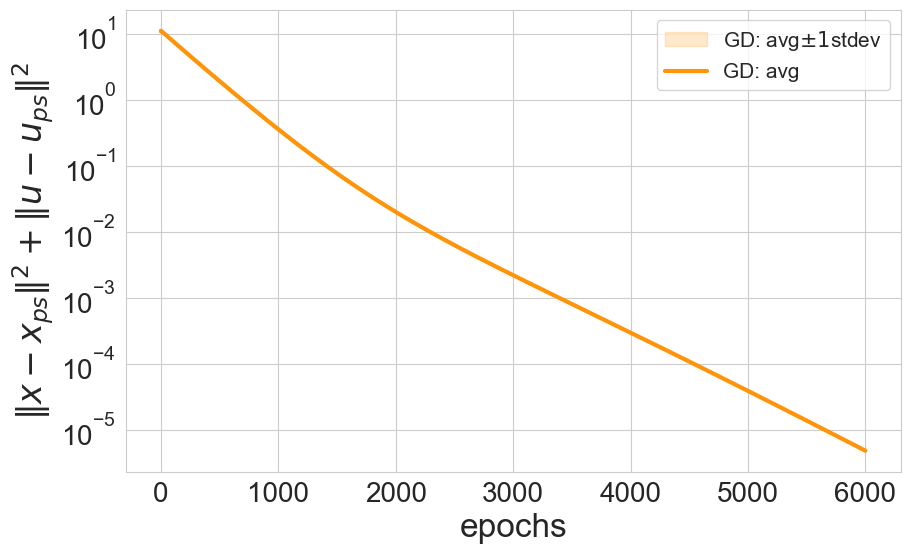

In [46]:
fs=24
import os
import seaborn as sns
sns.set_style("whitegrid")

cols=['xkcd:turquoise','xkcd:tangerine', 'xkcd:light lavender']
plt.figure(figsize=(10, 6))

plt.fill_between(range(6000 + burn_in + 1), mean_err_gp - std_err_gp, mean_err_gp + std_err_gp, color=cols[1], alpha=0.2, label='GD: avg$\pm 1$stdev')
plt.plot(range(6000 + burn_in + 1 ), mean_err_gp, label=r'GD: avg', color=cols[1], linewidth=3) # Enhanced visibility for mean trajectory
for i, result in enumerate(err_history_gp):
    plt.plot(range(6000 + burn_in +1), result, color=cols[1], alpha=0.2)  # Individual trajectories

plt.xlabel('epochs', fontsize=fs)
plt.ylabel('$\Vert x-x_{ps}\Vert^2 + \Vert u-u_{ps}\Vert^2$', fontsize=fs)
plt.yscale('log')
plt.legend(loc='upper right', fontsize=fs-9)
plt.tick_params(labelsize=fs-4)

figpath="./figs/"
if not(os.path.exists(figpath)): os.makedirs(figpath)
for tag in ['png','pdf']:
    plt.savefig(figpath+'rgm.'+tag, transparent=True, bbox_inches='tight',dpi=300 )